In [1]:
# Import libraries
!pip install pmdarima


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import os

# Set plot style
sns.set()


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\sophi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
### USER MUST CHANGE CSV_FILE NAME BELOW TO INTENDED FILE TO BE USED
# This file is the overall data (Time range: 01/01/2021 - 10/24/2023)
csv_file = "antidepressants_trends.csv"

filename = os.path.join(os.getcwd(), "data", csv_file)
column_name = csv_file.split("_")
column_name = column_name[0][0].upper() + column_name[0][1:] + " Searches"

df = pd.read_csv(filename, header=None, names=['Week', column_name], parse_dates=True)

# Subset the data starting from end of december of 2023
df = df.loc[df['Week'] < '2024-01-09']

# reformat the df
df = df.iloc[2:]  # Keeps all rows starting from the third (index 2 onwards)
df.reset_index(drop=True, inplace=True)

# Convert the search term column to numeric, forcing errors to NaN
df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
df.set_index('Week', inplace=True)

df.head()

,Antidepressants Searches
Week,
2021-01-10,51
2021-01-17,54
2021-01-24,57
2021-01-31,57
2021-02-07,51


In [10]:
# This file is the actual data to compare with forcasted data (Time range: 12/27/2023 - 10/19/2024*)
# *This date should be set to the week before the current week

filename_actual = os.path.join(os.getcwd(), "data", csv_file)
column_name_actual = csv_file.split("_")
column_name_actual = column_name_actual[0][0].upper() + column_name_actual[0][1:] + " Searches Actual"

df_actual = pd.read_csv(filename_actual, header=None, names=['Week', column_name_actual], parse_dates=True)

# Subset the data starting from end of december of 2023
df_actual = df_actual.loc[df_actual['Week'] >= '2023-12-16']

### Change the date to the week before the current week
df_actual = df_actual.loc[df_actual['Week'] < '2024-10-19']

# reformat the df_actual
df_actual = df_actual.iloc[2:]  # Keeps all rows starting from the third (index 2 onwards)
df_actual.reset_index(drop=True, inplace=True)

# Convert the search term column to numeric, forcing errors to NaN
df_actual[column_name_actual] = pd.to_numeric(df_actual[column_name_actual], errors='coerce')
df_actual.set_index('Week', inplace=True)

df_actual.head()

,Antidepressants Searches Actual
Week,
2023-12-31,47
2024-01-07,48
2024-01-14,49
2024-01-21,53
2024-01-28,54


In [11]:
# Identify outliers (you can use thresholds to define what constitutes an outlier)
threshold = df[column_name].mean() + 3 * df[column_name].std()

# Replace the spike with the median or a reasonable value
df[column_name] =   np.where(df[column_name] > threshold,
                    df[column_name].median(),
                    df[column_name])

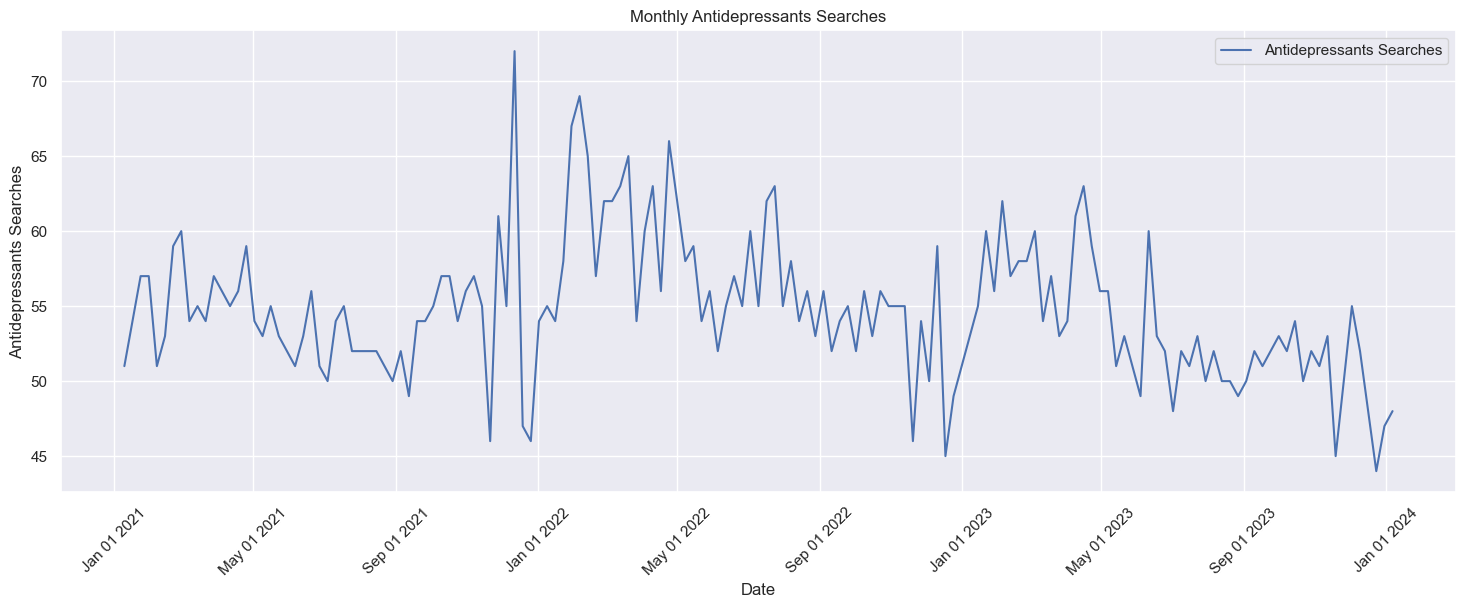

In [12]:
import matplotlib.dates as mdates

# Plot time series
df.index = pd.to_datetime(df.index, errors='coerce')

plt.figure(figsize=(18, 6))
plt.plot(df, label=column_name)
plt.title('Monthly ' + column_name)
plt.xlabel('Date')
plt.ylabel(column_name)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))  # Format as 'Jan 01 2021'
plt.xticks(rotation=45)

plt.legend()
plt.show()

In [13]:
# ADF test for stationarity
result = adfuller(df[column_name])
print(f'ADF Statistic: {result[0]}') # the more negative this value, the stronger the evidence that the time series is stationary
print(f'p-value: {result[1]}') # if the p-value is below a threshold (typically 0.05), it suggests that the time series is stationary

#If time series is not stationary, need to differenciate or use other transformations

ADF Statistic: -4.786331365193054
p-value: 5.77567063557946e-05


In [14]:
# Use auto_arima to find optimal params, auto_arima chooses best sarima model

## WARNING: This cell may take a while to run (approx time: 5-10m)

stepwise_model = auto_arima(df[column_name], seasonal=True, m=52, trace=True) # m=52 in order to make the model week based
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=941.354, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=896.156, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=872.251, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=939.356, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=883.863, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=868.576, Time=0.40 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=867.016, Time=8.75 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=18.06 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=932.934, Time=2.18 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=868.863, Time=11.26 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AIC=868.888, Time=5.16 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=inf,

In [15]:
sarima_model = SARIMAX(df[column_name],
                       order=stepwise_model.order,  # Optimal ARIMA order from auto_arima
                       seasonal_order=stepwise_model.seasonal_order, # optimal ARIMA seasonal order from auto_arima
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

C:\Users\sophi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\sophi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


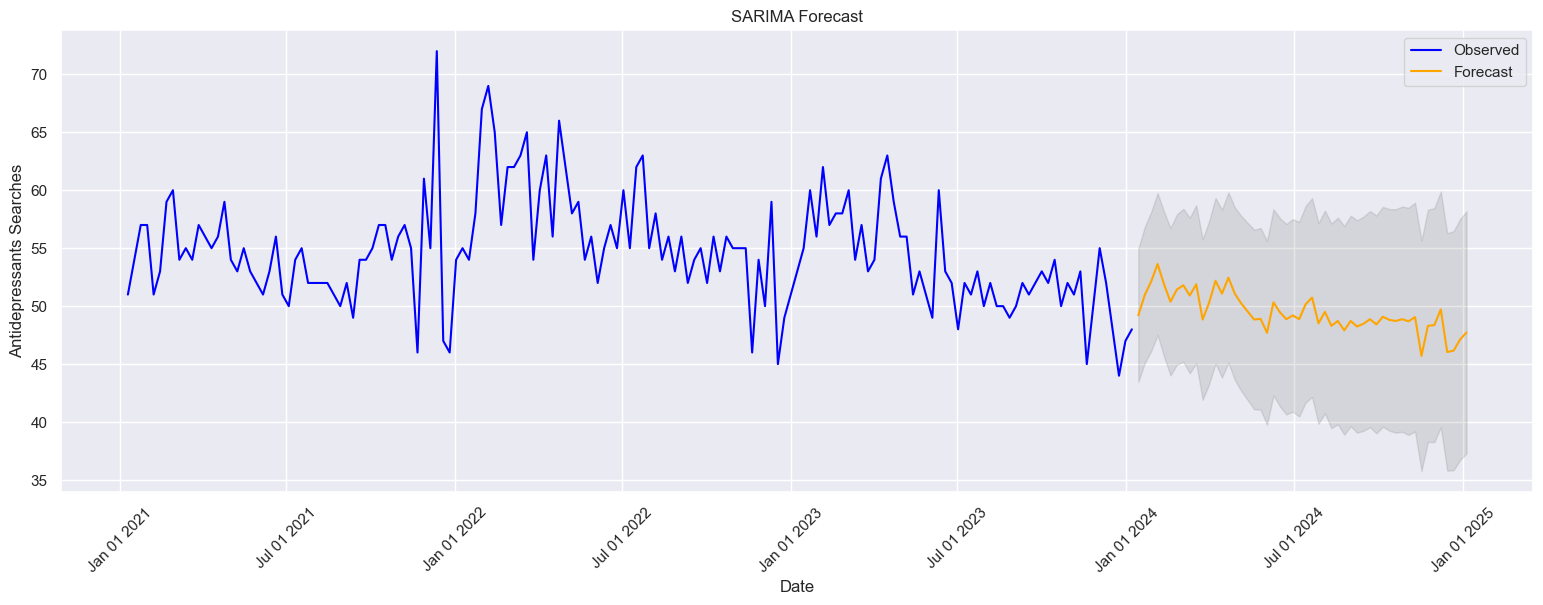

In [16]:
# predictions
# Forecast for the next 12 months
forecast = sarima_result.get_forecast(steps=52)

# Get confidence intervals
forecast_ci = forecast.conf_int()

# Ensure the 'Week' index is properly parsed without timezone
df.index = pd.to_datetime(df.index, errors='coerce')

# Ensure forecast index is also datetime without timezone
forecast.predicted_mean.index = pd.to_datetime(forecast.predicted_mean.index, errors='coerce')
forecast_ci.index = pd.to_datetime(forecast_ci.index, errors='coerce')

# Plot the forecast
plt.figure(figsize=(19, 6))
plt.plot(df.index, df[column_name], label='Observed', color='blue')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))  # Format as 'Jan 01 2021'
plt.xticks(rotation=45)

plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel(column_name)
plt.legend()
plt.show()

# Note: large gap between end of data and start of forcast

In [17]:
# Evaluate Model
# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

y_true = df[column_name][-52:]  # last 52 weeks
y_pred = forecast.predicted_mean
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 3.8322110689044235


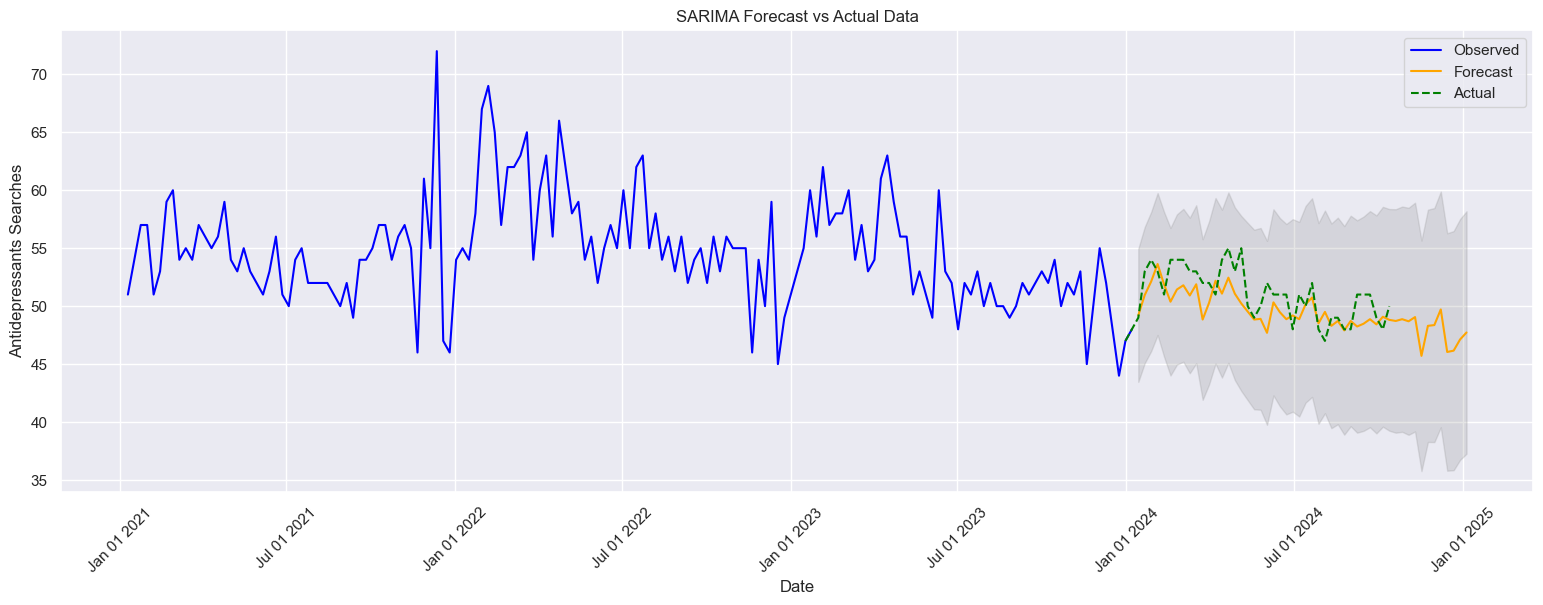

In [18]:
# Ensure forecast index is properly formatted
forecast.predicted_mean.index = pd.to_datetime(forecast.predicted_mean.index, errors='coerce')
forecast_ci.index = pd.to_datetime(forecast_ci.index, errors='coerce')

# Ensure the index of the actual data is also in datetime format
df_actual.index = pd.to_datetime(df_actual.index, errors='coerce')

# Plot the observed, forecast, and actual data
plt.figure(figsize=(19, 6))

# Plot the observed data (from your original df)
plt.plot(df.index, df[column_name], label='Observed', color='blue')

# Plot the forecasted data
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='orange')

# Plot the actual data from df_actual (overlayed on top of the forecast)
plt.plot(df_actual.index, df_actual[column_name_actual], label='Actual', color='green', linestyle='--')

# Add confidence intervals for the forecast
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)

# Formatting the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
plt.xticks(rotation=45)

# Add titles and labels
plt.title('SARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel(column_name)

# Add the legend to distinguish between the observed, forecasted, and actual data
plt.legend()

# Show the plot
plt.show()
